<a href="https://colab.research.google.com/github/suchy1713/ML-Learning/blob/master/4_unsupervised_dl/stacked_autoencoders_theano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""ann_theano_model.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xwn7DYqyEDKrdQ9atMc6LRIAOWGyLKMV
"""

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def init_weights(M1, M2):
    return np.random.randn(M1, M2)/np.sqrt(M1)

def error_rate(p, t):
    return np.mean(p != t)

class Autoencoder(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=True):
        N, D = X.shape
        n_batches = N//batch_sz

        W0 = init_weights(D, self.M)
        self.W = theano.shared(W0, 'W_'+str(self.id))
        self.bh = theano.shared(np.zeros(self.M), 'bh_'+str(self.id))
        self.bo = theano.shared(np.zeros(D), 'bo_'+str(self.id))
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W,  self.bh]

        self.dW = theano.shared(np.zeros((D, self.M)), 'dW_'+str(self.id))
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_'+str(self.id))
        self.dbo = theano.shared(np.zeros(D), 'dbo_'+str(self.id))
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.dforward_params = [self.dW,  self.dbh]

        X_in = T.matrix('X'+str(self.id))
        X_hat = self.forward_output(X_in)

        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H
        )

        cost = -(X_in*T.log(X_hat) + (1-X_in)*T.log(1-X_hat)).flatten().mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost
        )

        updates = [
                   (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
             (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]

        train_op = theano.function(
            inputs=[X_in],
            updates=updates
        )

        self.predict = theano.function(
                    inputs=[X_in],
                    outputs=X_hat,
                )

        costs = []
        print('Training autoencoder ' + str(self.id+1))
        for i in range(epochs):
            print('Epoch ', i+1, end=' ')
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                cost = cost_op(batch)
                costs.append(cost)
            print('Cost: ', cost)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        return Z

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y 


class StackedAE(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layers = []
        count = 0
        for M in hidden_layer_sizes:
            ae = Autoencoder(M, count)
            self.hidden_layers.append(ae)
            count += 1

    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.1, mu=0.99, reg=0, epochs=1, batch_sz=100):
        pretrain_epochs = int(pretrain)

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=2, show_fig=False)
            current_input = ae.hidden_op(current_input)

        N = len(Y)
        K = len(set(Y))
        W0 = init_weights(self.hidden_layers[-1].M, K)
        self.W = theano.shared(W0, 'W_lr')
        self.b = theano.shared(np.zeros(K), 'b_lr')

        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        self.dW = theano.shared(np.zeros((self.hidden_layers[-1].M, K)), 'dW_lr')
        self.db = theano.shared(np.zeros(K), 'db_lr')

        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.dforward_params

        X_in = T.matrix('X_in')
        targets = T.ivector('targets')
        pY = self.forward(X_in)

        reg_cost = T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(pY.shape[0]), targets])) + reg*reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs = [X_in, targets],
            outputs = [cost, prediction]
        )

        updates = [
                   (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
             (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]

        train_op = theano.function(
            inputs = [X_in, targets],
            updates = updates
        )

        n_batches = N // batch_sz
        costs = []

        print('Supervised learning:')
        for i in range(epochs):
            print('epoch ', i+1, end=' ')
            X, Y = shuffle(X, Y) 

            for j in range(n_batches):
                X_batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Y_batch = Y[j*batch_sz:(j*batch_sz + batch_sz)]

                train_op(X_batch, Y_batch)
                cost, prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(prediction, Ytest)
                costs.append(cost)
            print('Cost: ', cost, ' Error: ', error)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

Training autoencoder 1
Epoch  1 Cost:  0.2641845614538393
Epoch  2 Cost:  0.28083726863194985
Training autoencoder 2
Epoch  1 Cost:  0.6658532758905681
Epoch  2 Cost:  0.6757685063919143
Training autoencoder 3
Epoch  1 Cost:  0.5801523888288164
Epoch  2 Cost:  0.5707128352280502
Supervised learning:
epoch  1 

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Cost:  2.308396424194697  Error:  0.881
epoch  2 Cost:  2.2221439792396533  Error:  0.869
epoch  3 Cost:  2.073727821504011  Error:  0.767
epoch  4 Cost:  2.09064506886743  Error:  0.791
epoch  5 Cost:  2.023426159533727  Error:  0.721
epoch  6 Cost:  2.012176804931931  Error:  0.76
epoch  7 Cost:  1.9623978225465553  Error:  0.708
epoch  8 Cost:  1.9256583958237339  Error:  0.72
epoch  9 Cost:  1.8805838497270981  Error:  0.673
epoch  10 Cost:  1.8643852454164855  Error:  0.695
epoch  11 Cost:  1.762463247487934  Error:  0.648
epoch  12 Cost:  1.6721282661448484  Error:  0.644
epoch  13 Cost:  1.6415360383673656  Error:  0.653
epoch  14 Cost:  1.712439446603363  Error:  0.661
epoch  15 Cost:  1.5980878599222554  Error:  0.634
epoch  16 Cost:  1.5676849042054315  Error:  0.61
epoch  17 Cost:  1.5158012377592127  Error:  0.61
epoch  18 Cost:  1.4951693216666115  Error:  0.619
epoch  19 Cost:  1.4847492570001466  Error:  0.603
epoch  20 Cost:  1.443225413710164  Error:  0.57
epoch  21 Co

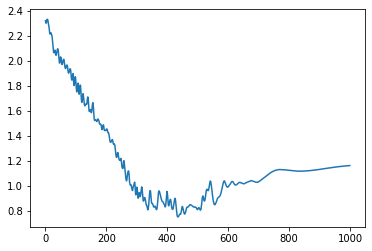

In [9]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
x_train, x_test, y_train, y_test = x_train[:1000, :], x_test[:1000, :], y_train[:1000], y_test[:1000]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train, y_test = y_train.astype(np.int32), y_test.astype(np.int32)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

dnn = StackedAE([1000, 750, 500])
dnn.fit(x_train, y_train, x_test, y_test, epochs=100)